In [2]:
import math
import torch

import matplotlib.pyplot as plt 

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
train_X = torch.linspace(0,1,15, dtype=dtype, device=device)
train_X = train_X.unsqueeze(1)

train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)

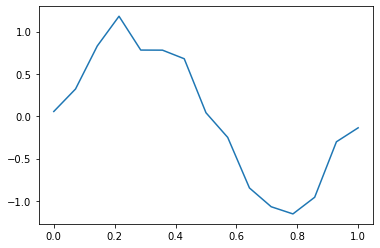

In [4]:
plt.plot(train_X.cpu(), train_Y.cpu())
plt.show()

### Initialize the model

PyTorch doesn't support inputing explicit bounds on the noise parameter. We need to manually register the constraint.

In [13]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan


model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

for i in model.parameters():
    print(i)

Parameter containing:
tensor([2.0000], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True)


### Define Marginal Log Likelihood
And... why do I need a marginal log likelihood? 

In [19]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

mll.parameters

<bound method Module.parameters of ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)>

### Define optimizer and specify parameters to optimize


In [7]:
from torch.optim import SGD

optimizer = SGD([{'params':model.parameters()}], lr=0.1)

### Fit model hyperparameters and noise level -- run the optimization loop

In [23]:
Num_epochs = 150

model.train() # Sets the module in training mode. Does NOT start training yet!

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [24]:
model.train_targets

tensor([ 0.0565,  0.3220,  0.8300,  1.1809,  0.7815,  0.7805,  0.6791,  0.0417,
        -0.2497, -0.8465, -1.0682, -1.1528, -0.9563, -0.3014, -0.1363],
       device='cuda:0')

In [ ]:
for epoch in range(Num_epochs):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output
    output = model(train_X)
    
    loss = - mll(output, model.train_targets)
    